In [394]:
import numpy as np
from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import boto3
from qiskit import QuantumCircuit
from qiskit_aer.backends.qasm_simulator import QasmSimulator
client = boto3.client("braket", region_name='us-west-1')

In [2]:
# create a circuit with a result type
circ = Circuit().rx(0, 1).ry(1, 0.2).cnot(0,2).variance(observable=Observable.Z(), target=0)
# add another result type
circ.probability(target=[0, 2])

# set up S3 bucket (where results are stored)
# my_bucket = "amazon-braket-your-s3-bucket-name" # the name of the bucket
# my_prefix = "your-folder-name" # the name of the folder in the bucket
# s3_location = (my_bucket, my_prefix)

Circuit('instructions': [Instruction('operator': Rx('angle': 1.0, 'qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.2, 'qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(2)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)], 'result_types': [Variance(observable=Z('qubit_count': 1), target=QubitSet([Qubit(0)])), Probability(target=QubitSet([Qubit(0), Qubit(2)]))])

In [3]:
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")# submit the quantum task to run
# my_task = device.run(circ, shots=1000, poll_timeout_seconds = 100, poll_interval_seconds = 10)
# the positional argument for the S3 bucket is optional if you want to specify a bucket other than the default

# get results of the quantum task
# result = my_task.result()

In [5]:
from pprint import pprint
from qiskit_braket_provider import AWSBraketProvider

In [6]:
provider = AWSBraketProvider()
backends = provider.backends()
backends

[BraketBackend[Aria 1],
 BraketBackend[Aria 2],
 BraketBackend[Aspen-10],
 BraketBackend[Aspen-11],
 BraketBackend[Aspen-8],
 BraketBackend[Aspen-9],
 BraketBackend[Aspen-M-1],
 BraketBackend[Aspen-M-2],
 BraketBackend[Aspen-M-3],
 BraketBackend[Forte 1],
 BraketBackend[Harmony],
 BraketBackend[Lucy],
 BraketBackend[SV1],
 BraketBackend[dm1]]

In [7]:
# state vector simulator
state_vector_simulator_backend = provider.get_backend("SV1")
state_vector_simulator_backend

BraketBackend[SV1]

In [241]:
from braket.quantum_information.pauli_string import PauliString
from qiskit.quantum_info.operators import SparsePauliOp

In [441]:
pauli_list = ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
pauli_index = [0, 6, 11, 13]
reward_factor = [0.25, 0.25, 0.25, -0.25]

In [442]:
isinstance(PauliString('IZ').to_unsigned_observable(), Observable)

True

In [443]:
from braket.circuits import Observable
from braket.circuits.observables import TensorProduct

%time
def create_tensor_product(pauli_list):
    tensor_products = []

    for pauli_str in pauli_list:
        # Initialize an empty list to hold the individual Pauli observables
        observables = []
        # Iterate over each character in the Pauli string
        for char in pauli_str:
            if char == 'I':
                observables.append(Observable.I())
            elif char == 'X':
                observables.append(Observable.X())
            elif char == 'Y':
                observables.append(Observable.Y())
            elif char == 'Z':
                observables.append(Observable.Z())
        # Create the tensor product from the list of observables
        if len(observables) > 1:
            tensor_product = TensorProduct(observables)
        else:
            tensor_product = observables[0]
        tensor_products.append(tensor_product)
    return tensor_products

# Example usage
ops_needed = [pauli_list[i] for i in pauli_index]
pauli_ops = create_tensor_product(ops_needed)

# Display the tensor products
for tp in pauli_ops:
    print(tp)


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 13.1 µs
TensorProduct(I('qubit_count': 1), I('qubit_count': 1))
TensorProduct(X('qubit_count': 1), Y('qubit_count': 1))
TensorProduct(Y('qubit_count': 1), Z('qubit_count': 1))
TensorProduct(Z('qubit_count': 1), X('qubit_count': 1))


In [447]:
sum_operator = sum([reward_factor[i] * pauli_ops[i].to_matrix() for i, _ in enumerate(pauli_index)])

In [448]:
sum_operator

array([[ 0.25+0.j  , -0.25+0.j  ,  0.  -0.25j,  0.  -0.25j],
       [-0.25+0.j  ,  0.25+0.j  ,  0.  +0.25j,  0.  +0.25j],
       [ 0.  +0.25j,  0.  -0.25j,  0.25+0.j  ,  0.25+0.j  ],
       [ 0.  +0.25j,  0.  -0.25j,  0.25+0.j  ,  0.25+0.j  ]])

In [446]:
observables_qiskit = SparsePauliOp.from_list(
    [
        (pauli_list[p], reward_factor[i])
        for i, p in enumerate(pauli_index)
    ]
)

In [430]:
observables_qiskit

SparsePauliOp(['II', 'XY', 'YZ', 'ZX'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])

In [431]:
observables_qiskit.to_matrix() == sum_operator

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [415]:
oberservable_braket = Observable.Hermitian(matrix=sum_operator)

In [416]:
oberservable_braket.to_matrix()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [399]:
braket_circuit = Circuit().x(range(2)).x(1)
print(braket_circuit)

T  : |0|1|
          
q0 : -X---
          
q1 : -X-X-

T  : |0|1|


In [400]:
braket_circuit.sample(observable=oberservable_braket, target=[0, 1])

Circuit('instructions': [Instruction('operator': X('qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': X('qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': X('qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)], 'result_types': [Sample(observable=Hermitian('qubit_count': 2, 'matrix': [[ 0.25+0.j    0.25+0.j    0.  +0.j    0.25-0.25j], [ 0.25+0.j    0.25+0.j    0.25-0.25j  0.  +0.j  ], [ 0.  +0.j    0.25+0.25j -0.25+0.j    0.25+0.j  ], [ 0.25+0.25j  0.  +0.j    0.25+0.j   -0.25+0.j  ]]), target=QubitSet([Qubit(0), Qubit(1)]))])

In [403]:
device = LocalSimulator()
result = device.run(braket_circuit, shots=1000).result()
np.mean(result.values)

-0.24704929088613398

In [404]:
result.measurement_counts

Counter({'00': 397, '01': 390, '11': 113, '10': 100})

AWS Braket Task Batching

In [449]:
from braket.circuits import Circuit, FreeParameter, Observable
from braket.aws import AwsQuantumTaskBatch

In [450]:
# create the free parameters
alpha = FreeParameter('alpha')
beta = FreeParameter('beta')

In [451]:
# create two circuits
circ_a = Circuit().rx(0, alpha).ry(1, alpha).cnot(0,2).xx(0, 2, beta)
circ_a.variance(observable=Observable.Z(), target=0)

circ_b = Circuit().rx(0, alpha).rz(1, alpha).cnot(0,2).zz(0, 2, beta)
circ_b.expectation(observable=Observable.Z(), target=2)

Circuit('instructions': [Instruction('operator': Rx('angle': alpha, 'qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Rz('angle': alpha, 'qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(2)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': ZZ('angle': beta, 'qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(2)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)], 'result_types': [Expectation(observable=Z('qubit_count': 1), target=QubitSet([Qubit(2)]))])

In [453]:
inputs_list = [{'alpha': 0.3,'beta':0.1}, {'alpha': 0.1,'beta':0.4}]

tasks = device.run_batch([circ_a, circ_b], inputs=inputs_list)

In [458]:
tasks.results()[1].values

[0.9950041652780257]

Conversion of Circuits: From Qiskit to Braket

In [473]:
from braket.circuits import (
    Circuit,
    FreeParameter,
    Instruction,
    gates,
    result_types,
    observables,
)
import warnings

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Measure, Parameter, ParameterVector
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Union

In [474]:
qiskit_gate_names_to_braket_gates: Dict[str, Callable] = {
    "u1": lambda lam: [gates.PhaseShift(lam)],
    "u2": lambda phi, lam: [
        gates.PhaseShift(lam),
        gates.Ry(np.pi / 2),
        gates.PhaseShift(phi),
    ],
    "u3": lambda theta, phi, lam: [
        gates.PhaseShift(lam),
        gates.Ry(theta),
        gates.PhaseShift(phi),
    ],
    "u": lambda theta, phi, lam: [
        gates.PhaseShift(lam),
        gates.Ry(theta),
        gates.PhaseShift(phi),
    ],
    "p": lambda angle: [gates.PhaseShift(angle)],
    "cp": lambda angle: [gates.CPhaseShift(angle)],
    "cx": lambda: [gates.CNot()],
    "x": lambda: [gates.X()],
    "y": lambda: [gates.Y()],
    "z": lambda: [gates.Z()],
    "t": lambda: [gates.T()],
    "tdg": lambda: [gates.Ti()],
    "s": lambda: [gates.S()],
    "sdg": lambda: [gates.Si()],
    "sx": lambda: [gates.V()],
    "sxdg": lambda: [gates.Vi()],
    "swap": lambda: [gates.Swap()],
    "rx": lambda angle: [gates.Rx(angle)],
    "ry": lambda angle: [gates.Ry(angle)],
    "rz": lambda angle: [gates.Rz(angle)],
    "rzz": lambda angle: [gates.ZZ(angle)],
    "id": lambda: [gates.I()],
    "h": lambda: [gates.H()],
    "cy": lambda: [gates.CY()],
    "cz": lambda: [gates.CZ()],
    "ccx": lambda: [gates.CCNot()],
    "cswap": lambda: [gates.CSwap()],
    "rxx": lambda angle: [gates.XX(angle)],
    "ryy": lambda angle: [gates.YY(angle)],
    "ecr": lambda: [gates.ECR()],
}


translatable_qiskit_gates = set(qiskit_gate_names_to_braket_gates.keys()).union(
    {"measure", "barrier", "reset"}
)

In [475]:
def convert_qiskit_to_braket_circuit(circuit: QuantumCircuit) -> Circuit:
    """Return a Braket quantum circuit from a Qiskit quantum circuit.
     Args:
            circuit (QuantumCircuit): Qiskit Quantum Cricuit

    Returns:
        Circuit: Braket circuit
    """
    quantum_circuit = Circuit()
    if not (
        {gate.name for gate, _, _ in circuit.data}.issubset(translatable_qiskit_gates)
    ):
        circuit = transpile(circuit, basis_gates=translatable_qiskit_gates)
    if circuit.global_phase > 1e-10:
        warnings.warn("Circuit transpilation resulted in global phase shift")
    # handle qiskit to braket conversion
    for qiskit_gates in circuit.data:
        name = qiskit_gates[0].name
        if name == "measure":
            # TODO: change Probability result type for Sample for proper functioning # pylint:disable=fixme
            # Getting the index from the bit mapping
            quantum_circuit.add_result_type(
                # pylint:disable=fixme
                result_types.Sample(
                    observable=observables.Z(),
                    target=[
                        circuit.find_bit(qiskit_gates[1][0]).index,
                        circuit.find_bit(qiskit_gates[2][0]).index,
                    ],
                )
            )
        elif name == "barrier":
            # This does not exist
            pass
        elif name == "reset":
            raise NotImplementedError(
                "reset operation not supported by qiskit to braket adapter"
            )
        else:
            params = []
            if hasattr(qiskit_gates[0], "params"):
                params = qiskit_gates[0].params

            for i, param in enumerate(params):
                if isinstance(param, Parameter):
                    params[i] = FreeParameter(param.name)

            for gate in qiskit_gate_names_to_braket_gates[name](*params):
                instruction = Instruction(
                    # Getting the index from the bit mapping
                    operator=gate,
                    target=[circuit.find_bit(i).index for i in qiskit_gates[1]],
                )
                quantum_circuit += instruction
    return quantum_circuit

In [485]:
def apply_parametrized_circuit(qc: QuantumCircuit):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    :param qc: Quantum Circuit instance to add the gates on
    :return:
    """
    # qc.num_qubits
    global n_actions
    params = ParameterVector('theta', n_actions)
    qc.u(2 * np.pi * params[0], 2 * np.pi * params[1], 2 * np.pi * params[2], 0)
    qc.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], 1)
    qc.rzx(2 * np.pi * params[6], 0, 1)

    return params

In [487]:
n_actions = 7
qiskit_circuit = QuantumCircuit(2)
param_vec = apply_parametrized_circuit(qiskit_circuit)

In [491]:
isinstance(param_vec[0], Parameter)

True

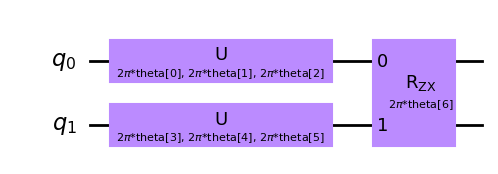

In [483]:
qiskit_circuit.draw('mpl')

In [484]:
convert_qiskit_to_braket_circuit(qiskit_circuit)

TypeError: ParameterExpression with unbound parameters ({ParameterVectorElement(theta[2])}) cannot be cast to a float.